# **Development of a model of analysis using well-known machine learning methods for classifying laboratory samples into clans**

## **Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

import missingno as msno
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from collections import Counter

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
from sklearn import preprocessing
from sklearn import metrics

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import all_estimators

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [ ]:
pd.set_option('display.max_columns', None)

## **EDA**

In [ ]:
df = pd.read_excel("dataset.xlsx")
df.head(10)

In [ ]:
rows = df.shape[0]
columns = df.shape[1]

print('Total rows:', rows)
print('Total columns:', columns)
print("Shape of the Dataset is:", df.shape)

In [ ]:
print(df.columns)
df.describe().transpose()

In [ ]:
msno.bar(df)

In [ ]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

rows_summary = pd.DataFrame({
    'Unique Values': dict,
    'Missing Values': df.isnull().sum(),
    'Dtype': df.dtypes
})

rows_summary

In [ ]:
duplicates = df.duplicated()

if duplicates.any():
    print("There are duplicates in the dataset.")
else:
    print("No duplicates were found.")

print(f"Number of duplicates: {duplicates.sum()}")

In [ ]:
rows = len(df)
population_name_percentages = (df['Clan'].value_counts() / rows) * 100
clan_counts = df['Clan'].value_counts()
unique_values = df['Clan'].unique()

clan_summary = pd.DataFrame({
    'Counts': clan_counts,
    'Percentage': population_name_percentages,
})

print(len(unique_values))
print(unique_values)
clan_summary

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Clan')
plt.title('Count of each Clan')
plt.xlabel('Clan')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

## **Model**

In [ ]:
X = df.drop(['Sample ID', 'Clan'], axis=1)
y = df['Clan']

In [ ]:
df_combined = pd.concat([X, y], axis=1)
class_counts = df_combined['Clan'].value_counts()
classes_to_keep = class_counts[class_counts >= 20].index
df_smote = df_combined[df_combined['Clan'].isin(classes_to_keep)]

X_smote = df_smote.drop('Clan', axis=1)
y_smote = df_smote['Clan']

In [ ]:
label_encoder = LabelEncoder()
y_smote_encoded = label_encoder.fit_transform(y_smote)

In [ ]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote_encoded)

print("Class distribution after resampling:", Counter(y_resampled))

In [ ]:
y_resampled_names = label_encoder.inverse_transform(y_resampled)

class_distribution_after_smote = Counter(y_resampled_names)
df_distribution_after_smote = pd.DataFrame(list(class_distribution_after_smote.items()), columns=['Clan', 'Count']).sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Clan', data=df_distribution_after_smote, palette='viridis')
plt.title('Clan distribution after SMOTE resampling')
plt.xlabel('Count')
plt.ylabel('Clan')
plt.tight_layout()
plt.show()

In [ ]:
print(X_resampled.shape)
X_resampled

In [ ]:
print(y_resampled.shape)
y_resampled

## **Random Forest**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,
                                  y_resampled, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)
X_train

In [ ]:
print(y_train.shape, y_test.shape)
y_train

In [ ]:
df_splits = pd.DataFrame({
    'Split': ['X_train', 'X_test', 'y_train', 'y_test'],
    'Description': [
        'Training set features',
        'Test set features',
        'Training set labels',
        'Test set labels'
    ],
    'Size': [len(X_train), len(X_test), len(y_train), len(y_test)]
})

df_splits

In [ ]:
dtc = DecisionTreeClassifier()

In [ ]:
class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 max_features='auto', bootstrap=True, oob_score=True, random_state=None, criterion='gini'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.random_state = random_state
        self.trees = []
        self.criterion = criterion
        self.sampled_indices_list = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        dataset = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        for _ in range(self.n_estimators):
            dataset_sample, sampled_indices = self.bootstrap_samples(dataset)
            X_sample, y_sample = dataset_sample[:, :-1], dataset_sample[:, -1]
            tree = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split,
                                          min_samples_leaf=self.min_samples_leaf, max_features=self.max_features,
                                          criterion=self.criterion)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            self.sampled_indices_list.append(sampled_indices)

        if self.oob_score:
            self.oob_score_ = self.calculate_oob_score(X, y)
        return self

    def bootstrap_samples(self, dataset):
        n_samples = dataset.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return dataset[indices], indices

    def calculate_oob_score(self, X, y_encoded):
        oob_predictions = np.zeros(len(y_encoded), dtype=float)
        for tree, sampled_indices in zip(self.trees, self.sampled_indices_list):
            unsampled_indices = np.setdiff1d(np.arange(len(y_encoded)), sampled_indices)
            if len(unsampled_indices) > 0:
                tree_predictions = tree.predict(X[unsampled_indices])
                oob_predictions[unsampled_indices] += tree_predictions.astype(float)

        oob_predictions /= self.n_estimators
        oob_predictions = np.round(oob_predictions).astype(int)
        oob_score = np.mean(y_encoded == oob_predictions)
        return oob_score


    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        preds = np.swapaxes(predictions, 0, 1)
        majority_predictions = np.array([self.most_common_label(pred) for pred in preds])
        return majority_predictions

    def most_common_label(self, y):
        return np.bincount(y).argmax()

In [ ]:
def confusion_matrix(y_true, y_pred):
    classes = np.unique(np.concatenate((y_true, y_pred)))
    num_classes = len(classes)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    class_to_index = {cls: idx for idx, cls in enumerate(classes)}

    for true, pred in zip(y_true, y_pred):
        true_index = class_to_index[true]
        pred_index = class_to_index[pred]
        cm[true_index, pred_index] += 1

    return cm

In [ ]:
def accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    return correct_predictions / total_samples

In [ ]:
def classification_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(np.concatenate((y_true, y_pred)))
    class_indices = {label: idx for idx, label in enumerate(classes)}
    num_classes = len(classes)

    report = "              precision    recall  f1-score   support\n\n"
    for cls in classes:
        idx = class_indices[cls]
        precision = cm[idx][idx] / sum(cm[:, idx]) if sum(cm[:, idx]) > 0 else 0
        recall = cm[idx][idx] / sum(cm[idx, :]) if sum(cm[idx, :]) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        support = sum(cm[idx, :])
        report += f"Class {cls}     {precision:.2f}       {recall:.2f}      {f1_score:.2f}       {support}\n"

    return report

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# model = RandomForestClassifier(bootstrap=False, max_depth=30,  max_features='auto', min_samples_leaf=1, min_samples_split=5, n_estimators=150, random_state=42)

# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

In [ ]:
rf_conf_matrix = confusion_matrix(y_test, y_pred)
rf_acc_score = accuracy(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy of the Random Forest is:", rf_acc_score * 100, "%")
print(rf_conf_matrix)
print(classification_rep)

In [ ]:
def predict_random_forest_with_array(new_sample):
    feature_names = ['DYS385a', 'DYS385b', 'DYS389I', 'DYS389II', 'DYS390', 'DYS391', 'DYS392', 'DYS393',
                     'DYS437', 'DYS438', 'DYS439', 'DYS448', 'DYS456', 'DYS458', 'DYS635', 'DYS19', 'GATA_H4']
    new_sample_df = pd.DataFrame(new_sample, columns=feature_names)
    prediction = model.predict(new_sample_df)
    predicted_class = label_encoder.inverse_transform(prediction)[0]
    return f"The prediction for the input data is: {predicted_class}"

new_sample = np.array([[12, 13, 14, 31, 25, 10, 11, 13, 10, 14, 11, 20, 15, 17, 24, 16, 10]]) # Baiuly

rf_result = predict_random_forest_with_array(new_sample)
rf_result

## **Neural Networks**

In [ ]:
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)

In [ ]:
print(X_train_nn.shape)
X_train_nn

In [ ]:
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

In [ ]:
print(y_train_nn.shape)
y_train_nn

In [ ]:
nn_model = Sequential([
    Dense(256, input_shape=(X_train_nn.shape[1],), activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train_nn.shape[1], activation='softmax')
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = nn_model.fit(X_train_nn, y_train_nn, epochs=200, validation_split=0.2, verbose=1)

In [ ]:
y_pred_nn_prob = nn_model.predict(X_test_nn)

y_pred_nn = np.argmax(y_pred_nn_prob, axis=1)
y_true_nn = np.argmax(y_test_nn, axis=1)

nn_conf_matrix = confusion_matrix(y_true_nn, y_pred_nn)
classification_rep_nn = classification_report(y_true_nn, y_pred_nn)

loss, accuracy_nn = nn_model.evaluate(X_test_nn, y_test_nn)

print("Accuracy of the Neural Networks is:", accuracy_nn * 100, "%")
print(nn_conf_matrix)
print(classification_rep_nn)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [ ]:
def predict_neural_network_with_array(new_sample):
    feature_names = ['DYS385a', 'DYS385b', 'DYS389I', 'DYS389II', 'DYS390', 'DYS391', 'DYS392', 'DYS393',
                     'DYS437', 'DYS438', 'DYS439', 'DYS448', 'DYS456', 'DYS458', 'DYS635', 'DYS19', 'GATA_H4']
    new_sample_df = pd.DataFrame(new_sample, columns=feature_names)
    new_sample_scaled = scaler.transform(new_sample_df)
    probabilities = nn_model.predict(new_sample_scaled)
    predicted_index = np.argmax(probabilities, axis=1)
    predicted_class = label_encoder.inverse_transform(predicted_index)[0]
    return f"The prediction for the input data is: {predicted_class}"

new_sample = np.array([[13, 13,	14,	29,	23,	10,	12,	13,	16,	10,	13,	22,	16,	15,	20,	13,	11]]) #Argyn

nn_result = predict_neural_network_with_array(new_sample)
nn_result

## **XGBoost**

In [ ]:
def tune_hyperparameters(clf, param_grid, X_train, y_train):
    """
    This function tunes the hyperparameters of a classifier using GridSearchCV and cross-validation
    and returns the best classifier model with the optimal hyperparameters.
    """

    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)

    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

In [ ]:
xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.04, 0.05, 0.06],
    'n_estimators': [150, 200, 250],
    'min_child_weight': [2, 3, 4],
    'scale_pos_weight': [0.2, 0.5, 0.8],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.3, 0.5, 0.8],
    'colsample_bylevel': [0.7, 0.8, 0.9],
    'reg_alpha': [0.01, 0.05, 0.1],
    'reg_lambda': [0.05, 0.1, 0.2],
    'max_delta_step': [1, 2, 3],
    'gamma': [0, 0.1, 0.2]
}

In [ ]:
y_train_encoded = label_encoder.fit_transform(y_train)

In [ ]:
xgb_classifier = XGBClassifier(random_state=0)
xgb_opt = tune_hyperparameters(xgb_classifier, xgb_param_grid, X_train, y_train_encoded)

In [ ]:
xgb_opt.fit(X_train, y_train)

In [ ]:
xgb_param_grid2 = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(xgb_opt, xgb_param_grid2, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best Model:", best_model)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

In [ ]:
y_pred_xgb = best_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print("Accuracy of the XGBoost is", accuracy_xgb * 100, "%")
print(f"Classification Report:\n{report_xgb}")

In [ ]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)

    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro'),
                                roc_auc_score(y_test, probabilities, multi_class='ovr', average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score','Macro AUC'],
                          columns = [model_name])

    result = (result * 100).round(2).astype(str) + '%'
    return result

In [ ]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''
    # Set font scale
    sns.set(font_scale=1.5)

    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap='Purples', ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')
    ax1.grid(False)

    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax2.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 3.6)
    table.set_fontsize(12)
    ax2.axis('tight')
    # Hide the axes
    ax2.axis('off')
    # set the title
    ax2.set_title('{} Performance Summary on Test Data'.format(model_name), fontsize=18)
    # Modify color
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('purple')

    plt.tight_layout()
    plt.show()

In [ ]:
model_evaluation(best_model, X_train, X_test, y_train, y_test, 'XGBoost')

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
history = best_model.fit(X_train, y_train, eval_set=eval_set, eval_metric=["mlogloss", "merror"], verbose=True)

# Получение истории обучения
results = best_model.evals_result()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train Loss')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation Loss')
plt.legend()
plt.title('XGBoost Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')

plt.subplot(1, 2, 2)
plt.plot(x_axis, 1 - np.array(results['validation_0']['merror']), label='Train Accuracy')
plt.plot(x_axis, 1 - np.array(results['validation_1']['merror']), label='Validation Accuracy')
plt.legend()
plt.title('XGBoost Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
def predict_with_xgboost(new_sample):
    feature_names = ['DYS385a', 'DYS385b', 'DYS389I', 'DYS389II', 'DYS390', 'DYS391', 'DYS392', 'DYS393',
                     'DYS437', 'DYS438', 'DYS439', 'DYS448', 'DYS456', 'DYS458', 'DYS635', 'DYS19', 'GATA_H4']
    new_sample_df = pd.DataFrame(new_sample, columns=feature_names)
    prediction_encoded = best_model.predict(new_sample_df)
    predicted_class = label_encoder.inverse_transform(prediction_encoded)[0]
    return f"The prediction for the input data is: {predicted_class}"

new_sample = np.array([[13, 13, 14, 29, 23, 10, 12, 13, 16, 10, 13, 22, 16, 15, 20, 13, 11]]) # Argyn

result = predict_with_xgboost(new_sample)
result

## **Results**

In [ ]:
results = {
    'Model': ['Random Forest', 'Neural Network', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, y_pred) * 100, accuracy_nn * 100, accuracy_xgb * 100],
    'Macro Precision': [precision_score(y_test, y_pred, average='macro') * 100, precision_score(y_true_nn, y_pred_nn, average='macro') * 100, precision_score(y_test, y_pred_xgb, average='macro') * 100],
    'Macro Recall': [recall_score(y_test, y_pred, average='macro') * 100, recall_score(y_true_nn, y_pred_nn, average='macro') * 100, recall_score(y_test, y_pred_xgb, average='macro') * 100],
    'Macro F1-score': [f1_score(y_test, y_pred, average='macro') * 100, f1_score(y_true_nn, y_pred_nn, average='macro') * 100, f1_score(y_test, y_pred_xgb, average='macro') * 100],
}

results_df = pd.DataFrame(results)
results_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = label_encoder.classes_
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_true_nn, y_pred_nn, "Neural Network Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

In [ ]:
# new_sample = np.array([[12, 13, 14, 31, 25, 10, 11, 13, 14, 10, 11, 20, 15, 17, 23, 16, 10]]) # Alimuly 0
# new_sample = np.array([[13, 13, 14, 29, 23, 10, 12, 13, 16, 10, 13, 22, 16, 15, 20, 13, 11]]) # Argyn
# new_sample = np.array([[13, 13, 14, 29, 23, 10, 12, 13, 16, 10, 13, 22, 16, 15, 20, 13, 11]]) # Argyn 1
# new_sample = np.array([[12, 13, 14, 31, 25, 11, 11, 13, 14, 10, 11, 20, 15, 17, 24, 16, 10]]) # Baiuly 2
# new_sample = np.array([[12, 13, 14, 31, 25, 10, 11, 13, 10, 14, 11, 20, 15, 17, 24, 16, 10]]) # Baiuly
# new_sample = np.array([[14, 13, 13, 31, 23, 11, 15, 13, 13, 11, 13, 19, 15, 17, 22, 13, 11]]) # Kanly 3
# new_sample = np.array([[11, 13, 13, 29, 25, 10, 11, 13, 14, 10, 10, 22, 15, 19, 21, 16, 11]]) # Kanly
# new_sample = np.array([[11, 14, 14, 30, 23, 11, 14, 14, 10, 14, 10, 19, 13, 17, 21, 16, 12]]) # Kerderi 4
# new_sample = np.array([[11, 14, 14, 30, 23, 11, 14, 14, 10, 14, 10, 19, 13, 17, 21, 16, 12]]) # Kerderi
# new_sample = np.array([[15, 12, 14, 32, 24, 11, 11, 12, 10, 14, 12, 20, 16, 15, 21, 13, 12]]) # Kereit 5
# new_sample = np.array([[12, 13, 13, 29, 25, 10, 11, 13, 14, 10, 10, 23, 15, 18, 21, 16, 11]]) # Kerey 6
# new_sample = np.array([[11, 14, 13, 29, 23, 10, 11, 14, 14, 10, 12, 21, 15, 18, 21, 16, 11]]) # Konyrat 7
# new_sample = np.array([[11, 13, 13, 32, 25, 10, 11, 13, 14, 11, 11, 20, 15, 15, 23, 16, 12]]) # Kozha 8
# new_sample = np.array([[11, 14, 12, 29, 22, 10, 14, 14, 14, 10, 12, 19, 15, 14, 22, 15, 11]]) # Kulegen 9
# new_sample = np.array([[13, 13, 14, 30, 19, 11, 13, 13, 14, 10, 13, 19, 15, 17, 24, 14, 10]]) # Kypshak 10
# new_sample = np.array([[12, 13, 13, 29, 25, 10, 11, 13, 14, 10, 10, 22, 15, 17, 21, 16, 11]]) # Kyrgyz 11
# new_sample = np.array([[12, 13, 14, 30, 25, 10, 11, 13, 14, 10, 10, 22, 15, 18, 21, 16, 11]]) # Mangyt 12
# new_sample = np.array([[12, 13, 13, 29, 25, 10, 11, 13, 14, 10, 10, 23, 15, 18, 21, 16, 11]]) # Naiman 13
# new_sample = np.array([[11, 13, 13, 30, 25, 10, 11, 13, 11, 14, 10, 20, 16, 18, 23, 15, 12]]) # Ramadan 14
# new_sample = np.array([[12, 13, 13, 30, 25, 10, 11, 13, 14, 10, 10, 22, 16, 18, 21, 16, 11]]) # Shanyshkyly 15
# new_sample = np.array([[9, 12, 13, 29, 22, 11, 13, 12, 16, 10, 12, 19, 15, 18, 21, 16, 11]]) # Sunak 16
# new_sample = np.array([[12, 13, 14, 32, 24, 9, 11, 13, 10, 14, 11, 20, 15, 19, 22, 15, 10]]) # Tabyn 17
# new_sample = np.array([[12, 13, 13, 29, 25, 10, 11, 13, 10, 14, 10, 22, 15, 17, 21, 17, 11]]) # Tama 18
# new_sample = np.array([[11, 13, 13, 30, 25, 11, 11, 13, 14, 11, 11, 21, 17, 15, 23, 15, 12]]) # Tarakty 19
# new_sample = np.array([[13, 12, 13, 29, 24, 10, 11, 12, 10, 15, 11, 19, 15, 19, 21, 14, 11]]) # Teleu 20
# new_sample = np.array([[13, 13, 15, 30, 23, 10, 12, 13, 16, 10, 13, 22, 16, 15, 20, 13, 11]]) # Tore 21
# new_sample = np.array([[11, 14, 14, 30, 23, 10, 14, 14, 14, 10, 10, 19, 14, 17, 22, 14, 12]]) # Uak 22
# new_sample = np.array([[15, 13, 13, 30, 24, 10, 11, 13, 14, 10, 11, 20, 17, 15, 22, 13, 12]]) # Uissun 23
# new_sample = np.array([[13, 13, 14, 29, 23, 10, 12, 13, 10, 16, 13, 22, 16, 15, 20, 13, 11]]) # Zhagabaily 24
# new_sample = np.array([[13, 12, 13, 29, 24, 10, 11, 12, 15, 9, 11, 19, 15, 20, 21, 14, 11]]) # Zhalaiyr 25
# new_sample = np.array([[12, 13, 13, 28, 25, 10, 11, 13, 14, 10, 10, 22, 16, 17, 21, 17, 11]]) # Zhetiru 26

## **STR markers analysis**

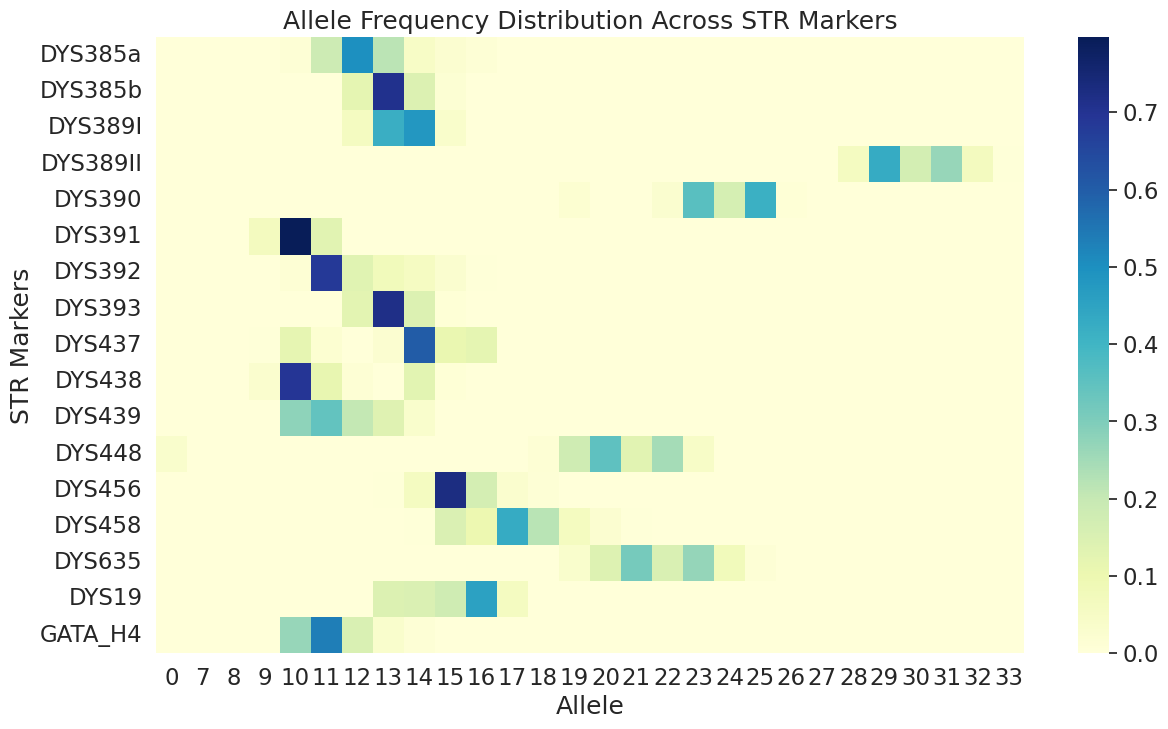

In [ ]:
# 1. Allele Frequency Distribution
allele_freq = X.apply(lambda x: x.value_counts(normalize=True)).fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(allele_freq.T, cmap="YlGnBu", cbar=True)
plt.title('Allele Frequency Distribution Across STR Markers')
plt.xlabel('Allele')
plt.ylabel('STR Markers')
plt.show()

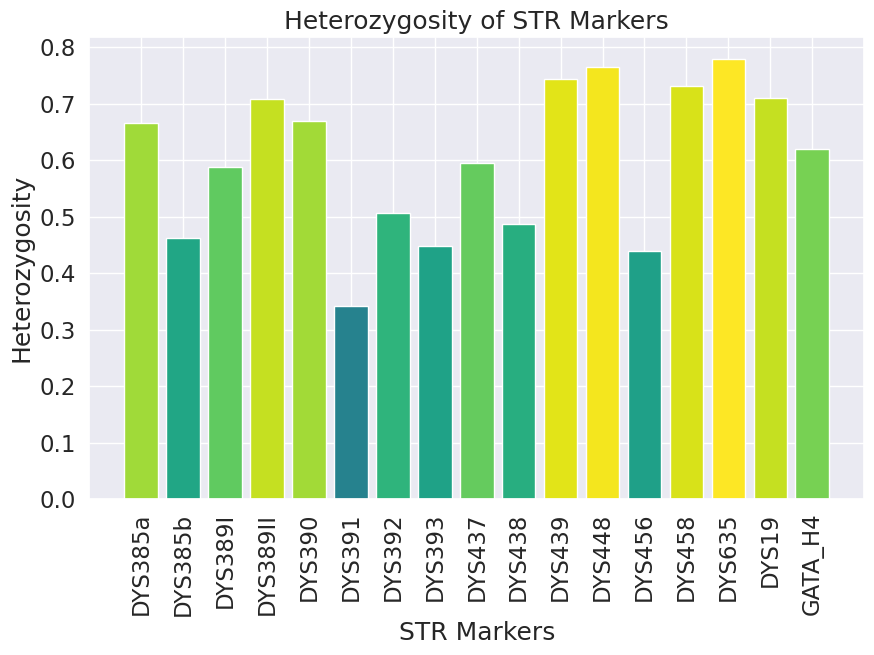

In [ ]:
# 2. Heterozygosity and PIC calculation
def calculate_heterozygosity(column):
    freq = column.value_counts(normalize=True)
    return 1 - np.sum(freq ** 2)

heterozygosity = X.apply(calculate_heterozygosity)

# Create a color gradient
colors = plt.cm.viridis(heterozygosity.values / max(heterozygosity))

plt.figure(figsize=(10, 6))
bars = plt.bar(heterozygosity.index, heterozygosity.values, color=colors)
plt.title('Heterozygosity of STR Markers')
plt.xlabel('STR Markers')
plt.ylabel('Heterozygosity')
plt.xticks(rotation=90)
plt.show()

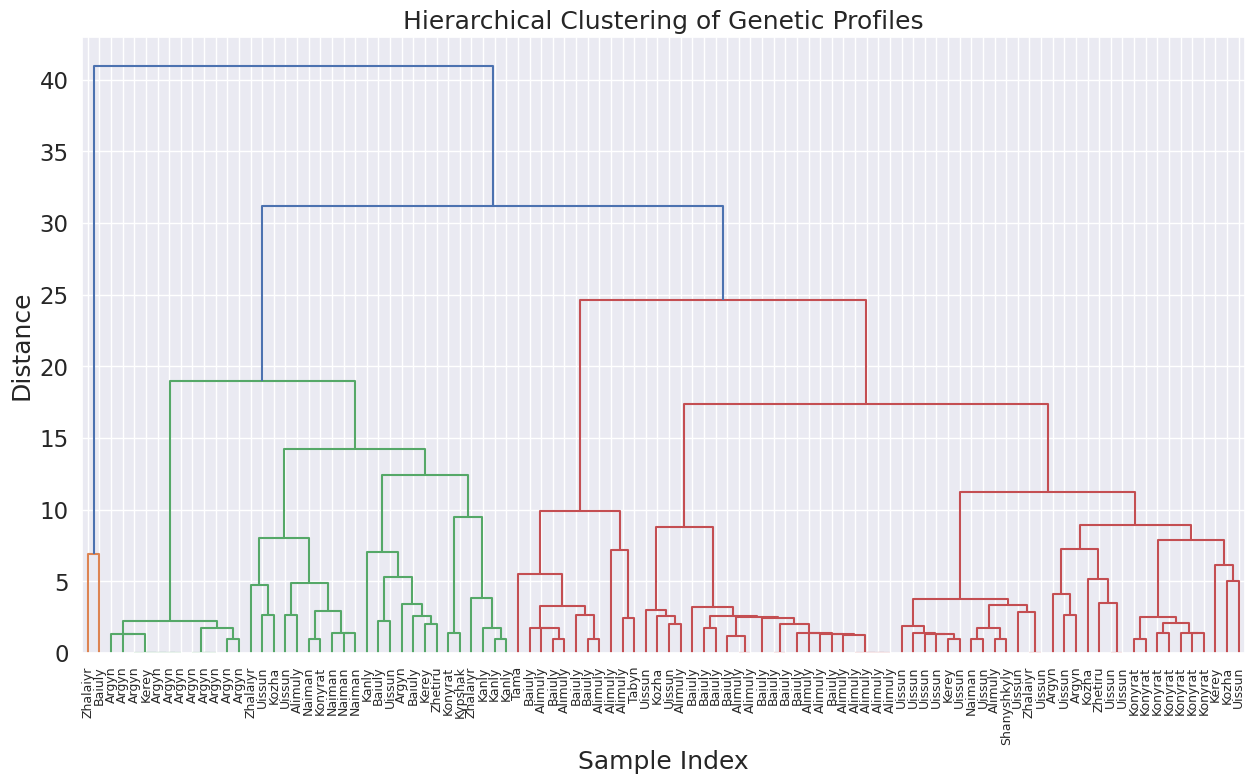

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

# 3. Genetic Clustering (Hierarchical Clustering)
# Limit the dataset to a smaller sample for dendrogram visualization
sampled_data = X.sample(n=100, random_state=42)
sampled_target = y[sampled_data.index]

# Calculate the linkage matrix
Z = linkage(sampled_data, 'ward')

plt.figure(figsize=(15, 8))
dendrogram(Z, labels=sampled_target.values, leaf_rotation=90, leaf_font_size=9)
plt.title('Hierarchical Clustering of Genetic Profiles')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

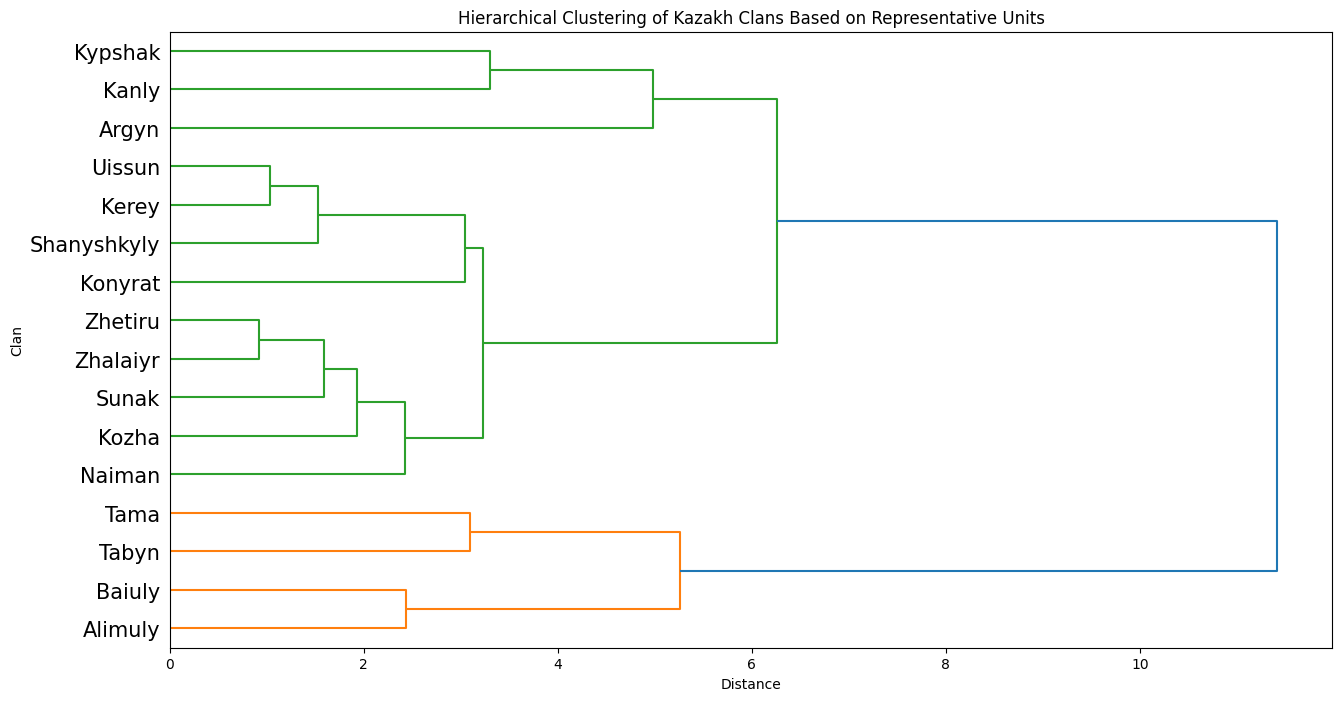

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

representative_units = X.groupby(y).mean()

# Perform hierarchical clustering
Z = linkage(representative_units, 'ward')

plt.figure(figsize=(15, 8))
dendrogram(Z, labels=representative_units.index, leaf_rotation=0, leaf_font_size=15, orientation='right')
plt.title('Hierarchical Clustering of Kazakh Clans Based on Representative Units')
plt.ylabel('Clan')
plt.xlabel('Distance')
plt.show()

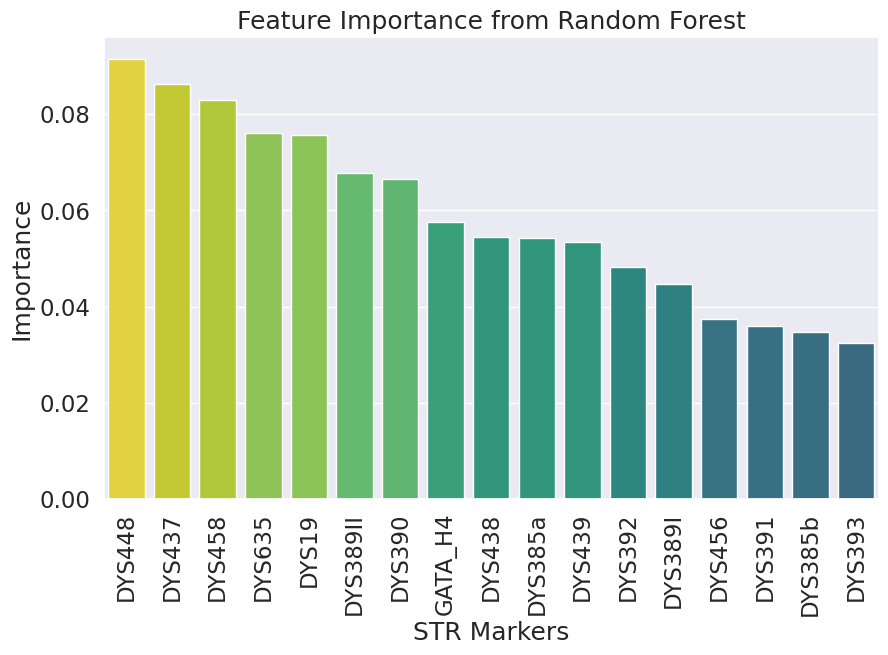

In [ ]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

colors = plt.cm.viridis(importances[indices] / max(importances))

plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns[indices], y=importances[indices], palette=colors)
plt.title('Feature Importance from Random Forest')
plt.xlabel('STR Markers')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()